In [151]:
from rfgap import RFGAP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from dataset import dataprep, load_regression
from phate import PHATE

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

sns.set_theme()

In [152]:
# TODO: Write a module to read in and prepare data from repo

In [153]:
data_names = ['AirfoilSelfNoise', 'AirQuality', 'Automobile', 'AutoMPG',
              'BeijingPM25', 'CommunityCrime', 'ComputerHardware',
              'ConcreateCompressiveStrength', 'ConcreteSlumpTest', 
              'CyclePowerPlant', 'EnergyEfficiency', 'FacebookMetrics',
              'FiveCitiesPM25', 'Hydrodynamics', 'IstanbulStock', 
              'Naval Propulsion Plants', 'OpticalNetwork', 
              'Parkinsons', 'Protein', 'SML2010']

In [154]:
data_name = 'AirfoilSelfNoise'
x, y = load_regression('../datasets/regression/' + data_name)
n, d   = x.shape

In [155]:
# TODO: Add these to RFGAP

def is_in_interval(y, lwr, upr):
    return np.logical_and(y >= lwr, y <= upr)

def get_coverage(y, y_lwr, y_upr):
    return np.mean((y >= y_lwr) & (y <= y_upr))

In [156]:
x_train, x_test, y_train, y_test, inds_train, inds_test = train_test_split(x, y, np.arange(n), test_size=0.1, random_state = 42)

In [157]:
# Random forest on all data for PHATE embedding visualization
rfphate = RFGAP(oob_score = True, non_zero_diagonal = True, random_state = 42, y = y)
rfphate.fit(x, y)
prox_phate = rfphate.get_proximities()

In [158]:
# Random forest for uncertainty measures; using split datasets
rf = RFGAP(oob_score = True, random_state = 42, y = y)
rf.fit(x_train, y_train)
prox = rf.get_proximities()

In [159]:
y_pred_test, y_pred_lwr_test, y_pred_upr_test = rf.predict_interval(X_test = x_test, n_neighbors = 'auto', level = 0.95)

In [160]:
sort_idx = y_pred_test.argsort()
y_grid = np.linspace(np.min(y_test), np.max(y_test), len(y_test))
is_covered = is_in_interval(y_test, y_pred_lwr_test, y_pred_upr_test)

In [165]:
get_coverage(y_test, y_pred_lwr_test, y_pred_upr_test)

0.9271523178807947

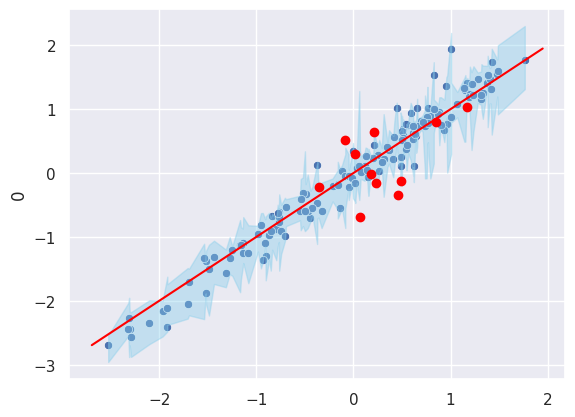

In [161]:
# plt.scatter(y_pred_test, y_test) # Add intervals


sns.scatterplot(x = y_pred_test, y = y_test)
plt.fill_between(np.sort(y_pred_test), y_pred_lwr_test[sort_idx],
                 y_pred_upr_test[sort_idx], color='skyblue', alpha=0.4)

plt.plot(y_grid, y_grid, color = 'red')

plt.scatter(y_pred_test[~is_covered], y_test[~is_covered], color = 'red')




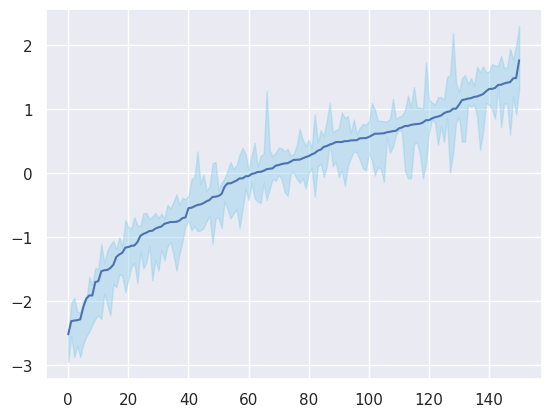

In [162]:
plt.plot(y_pred_test[sort_idx]) # Add intervals
plt.fill_between(range(len(y_test)), y_pred_lwr_test[sort_idx], 
                 y_pred_upr_test[sort_idx], color='skyblue', alpha=0.4, label='Confidence Interval')

In [ ]:
# TODO: Run for multiple values of k across multiple datasets. 
# Keep widths, coverages
# Compare with Zhang et al. 2020 and Quantile Regression